In [1]:
import segyio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
import os
import glob
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from utils import *

## Build Model

In [2]:
class ContractingBlock(nn.Module):

    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)  #加入dropout layer 去避免 overfitting
       

    def forward(self, x):

        x = self.conv1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x
    
def crop(image, new_shape):

    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]

    return cropped_image

class ExpandingBlock(nn.Module):

    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)      
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3, padding=(1,1))
        self.dropout = nn.Dropout(0.3)
        
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):

        x = self.upsample(x)
        x = self.conv1(x)    
        skip_con_x = crop(skip_con_x, x.shape)    
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

class FeatureMapBlock(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        
    def forward(self, x):
  
        x = self.conv(x)
        return x

class UNet(nn.Module):

    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        
    def forward(self, x):
                 
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)      
        x2 = self.contract2(x1)     
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)
        xn_upsampled = F.interpolate(xn, size=x.size()[2:], mode='bilinear', align_corners=False)
        return xn_upsampled

### Support Functions

In [3]:
def crop_input(image, new_shape):
    
    h, w = image.shape[0], image.shape[1]   # values inside the brackets depends on the input shapes
    new_h, new_w = new_shape[0], new_shape[1]
    
    start_h = int((h - new_h + 1)/2)
    start_w = int((w - new_w + 1)/2)
    
    cropped_image = image[start_h:start_h + new_h, start_w:start_w + new_w] 
    
    return cropped_image

def pad_to(image, new_shape):
    '''
    Function for padding an image tensor. 
    If somehow the expanding layer output and the skip connection doesn't match,
    these might be helpful.
    '''
    h, w = image.shape[0], image.shape[1]
    new_h, new_w = new_shape[0], new_shape[1]
    
    inc_h, inc_w = new_h -h, new_w - w
    left, right = 0, inc_w
    top, bottom = 0, inc_h
    pads = left, right, top, bottom 
    
    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    padded_image = F.pad(image, pads, "constant", 0)

    return padded_image

def dice_score(pred, target, threshold=0.7):
    pred = pred > threshold  # Convert to binary mask
    target = target > threshold  # Convert to binary mask
    intersection = (pred & target).sum().float()
    union = pred.sum() + target.sum()
    return 2 * intersection / union if union != 0 else torch.tensor(1.0)

### Dataset

In [4]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, root_dir, new_shape, transform=None):
        self.root_dir = root_dir
        self.new_shape = new_shape
        self.transform = transform
        
        self.samples = []
        
        folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        folders.sort()
        
        for folder in folders:
            folder_path = os.path.join(root_dir, folder)
            
            # 找出該資料夾中的 seismic 與 fault 檔案
            seismic_files = glob.glob(os.path.join(folder_path, 'seismicCubes_*.npy'))
            fault_files = glob.glob(os.path.join(folder_path, 'fault_*.npy'))
            
            if len(seismic_files) == 1 and len(fault_files) == 1:
                seismic_file = seismic_files[0]
                fault_file = fault_files[0]

                seismic_data = np.load(seismic_file, mmap_mode='r') # 使用mmap_mode以降低記憶體壓力
                fault_data = np.load(fault_file, mmap_mode='r')
                D = seismic_data.shape[0]
                
                # 將每個 inline 的 index 及對應檔案路徑記錄下來
                for i in range(D):
                    self.samples.append((seismic_file, fault_file, i))
            else:
                print(f"Skipping {folder_path}: 不符合檔案數量條件")
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        seismic_file, fault_file, inline_idx = self.samples[idx]

        # 載入第 inline_idx 張 slice
        # 使用 mmap_mode='r' 可以在需要時讀取，避免整個檔案載入至記憶體
        seismic_data = np.load(seismic_file, mmap_mode='r')
        fault_data = np.load(fault_file, mmap_mode='r')
        
        # 取出指定的 inline
        seismic_inline = seismic_data[inline_idx]
        fault_inline = fault_data[inline_idx]
        
        # 做 rescale 與 crop
        seismic_inline = rescale_volume(seismic_inline, low=2, high=98)
        
        # 轉成 tensor
        seismic_tensor = torch.from_numpy(seismic_inline).float()
        fault_tensor = torch.from_numpy(fault_inline.copy()).float()

        # crop
        seismic_tensor = crop_input(seismic_tensor, self.new_shape).unsqueeze(0)  # (1, H, W)
        fault_tensor = crop_input(fault_tensor, self.new_shape).unsqueeze(0)      # (1, H, W)
        
        return seismic_tensor, fault_tensor

### Train

In [5]:
# Hyperparameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 30   
display_step = 100
batch_size = 1
lr = 0.00001

dir_path = "training_data"
dataset = CustomSegmentationDataset(root_dir=dir_path, new_shape=(256, 256))
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)

In [6]:
def train():
    dataset = CustomSegmentationDataset(root_dir=dir_path, new_shape=(256, 256))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    unet = UNet(1, 1).to(device)
    if os.path.isfile('2dcnn_best.pth'):  # Ensure the file exists
        unet.load_state_dict(torch.load('2dcnn_best.pth', map_location=device))
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(unet_opt, mode='min', patience=3, factor=0.5)
    
    train_losses = []
    min_loss = float('inf')
    best_dice = 0.0
    for epoch in range(n_epochs):
        cur_step = 0
        no_improvement_step = 0
        max_no_improvement_step = 20
        epoch_loss = 0.0
        epoch_dice = 0.0
        step_dice = 0.0
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels.to(device)
            
            # Forward pass
            unet_opt.zero_grad()
            pred = unet(real)
            unet_loss = criterion(pred, labels)

            dice = dice_score(pred, labels, 0.3)
            epoch_dice += dice.item()
            step_dice += dice.item()
            
            # Backward pass
            unet_loss.backward()
            unet_opt.step()
            epoch_loss += unet_loss.item()
            
            if cur_step % display_step == 0 and cur_step != 0:
                avg_loss = epoch_loss/(cur_step+1)
                avg_dice = epoch_dice/(cur_step+1)
                step_dice /= display_step
                print(f"Epoch {epoch}, Step {cur_step}, Loss: {avg_loss:.4f}, Dice: {avg_dice:.4f}, Step Dice: {step_dice:.4f}")

                if step_dice > best_dice:
                    best_dice = step_dice
                    no_improvement_step = 0  # Reset counter if improvement
                    torch.save(unet.state_dict(), '2dcnn_best.pth')
                else:
                    no_improvement_step += 1
                step_dice = 0.0
                if no_improvement_step >= max_no_improvement_step:
                    print(f"Early stopping at Epoch {epoch}, Step {cur_step}. \nDice score did not improve.")
                    return unet, train_losses
            cur_step += 1
        
        # 平均 epoch loss
        epoch_loss /= len(dataloader)
        train_losses.append(epoch_loss)

        # 調整學習率
        scheduler.step(epoch_loss)

        print(f"Epoch {epoch} finished. Average loss: {epoch_loss:.4f}")

    return unet, train_losses

In [7]:
model, loss = train()
# torch.save(model.state_dict(), 'model_part1.pth')

  0%|          | 0/96000 [00:00<?, ?it/s]

Epoch 0, Step 100, Loss: 0.0225, Dice: 0.7007, Step Dice: 0.7077
Epoch 0, Step 200, Loss: 0.0272, Dice: 0.6622, Step Dice: 0.6233
Epoch 0, Step 300, Loss: 0.0272, Dice: 0.6581, Step Dice: 0.6500
Epoch 0, Step 400, Loss: 0.0308, Dice: 0.6574, Step Dice: 0.6552
Epoch 0, Step 500, Loss: 0.0317, Dice: 0.6513, Step Dice: 0.6266
Epoch 0, Step 600, Loss: 0.0314, Dice: 0.6519, Step Dice: 0.6554
Epoch 0, Step 700, Loss: 0.0319, Dice: 0.6470, Step Dice: 0.6176
Epoch 0, Step 800, Loss: 0.0317, Dice: 0.6465, Step Dice: 0.6426
Epoch 0, Step 900, Loss: 0.0314, Dice: 0.6431, Step Dice: 0.6163
Epoch 0, Step 1000, Loss: 0.0301, Dice: 0.6482, Step Dice: 0.6942
Epoch 0, Step 1100, Loss: 0.0295, Dice: 0.6502, Step Dice: 0.6702
Epoch 0, Step 1200, Loss: 0.0301, Dice: 0.6467, Step Dice: 0.6083
Epoch 0, Step 1300, Loss: 0.0311, Dice: 0.6404, Step Dice: 0.5649
Epoch 0, Step 1400, Loss: 0.0309, Dice: 0.6420, Step Dice: 0.6618
Epoch 0, Step 1500, Loss: 0.0309, Dice: 0.6455, Step Dice: 0.6947
Epoch 0, Step 1600,

### Inference

In [4]:
def inference(model,input: np.ndarray, threshold = 0.7, show_progress = False) -> np.ndarray:
    model.eval()
    slices, width, height = input.shape
    model_shape = (256,256)

    output = np.zeros(input.shape, dtype=np.float32)
    weight_map = np.zeros(input.shape, dtype=np.float32)

    # Define the stride based on the model shape (90% overlap)
    stride = tuple(int(s * 0.9) for s in model_shape)
    
    # Ensure full coverage by calculating the number of steps in each dimension
    steps_x = range(0, width - model_shape[0] + 1, stride[0])
    steps_y = range(0, height - model_shape[1] + 1, stride[1])

    # Add final steps to cover the edges if necessary
    if (width - model_shape[0]) % stride[0] != 0:
        steps_x = list(steps_x) + [width - model_shape[0]]
    if (height - model_shape[1]) % stride[1] != 0:
        steps_y = list(steps_y) + [height - model_shape[1]]
    
    with torch.no_grad():
        iterator = tqdm(range(slices), desc="Processing slices") if show_progress else range(slices)
        for i in iterator:
            slice = torch.from_numpy(input[i]).unsqueeze(0).unsqueeze(0).to(device)
            for j in steps_x:
                for k in steps_y:
                    patch_pred = model(slice[:, :, j:j + model_shape[0], k:k + model_shape[1]])
                    patch_pred = patch_pred.squeeze().cpu().numpy().astype(np.float32)
                    output[i, j:j + model_shape[0], k:k + model_shape[1]] += patch_pred
                    weight_map[i, j:j + model_shape[0], k:k + model_shape[1]] += 1
            # print(f"slice: {i}")
    # weight_map[weight_map == 0] = 1
    output /= weight_map
    output = (output > threshold).astype(np.uint8)
    return output


In [9]:
data = np.load("validation_data/2023-10-05_d8f1c416/seismicCubes_RFC_fullstack_2023.76141493.npy")
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
unet = UNet(1, 1).to(device)
unet.load_state_dict(torch.load('2dcnn_best.pth', map_location=device))
pred = inference(unet,data,0.3)

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

因為分數最佳為0.341152->改3Dunet來達到更好的結果

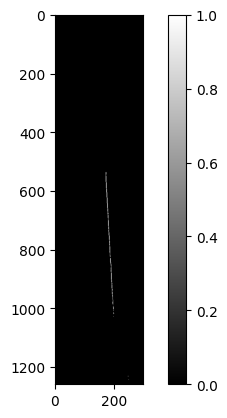

0.7043066365386225


In [10]:
from matplotlib import pyplot as plt
# Plot the second image with a colorbar
im = plt.imshow(pred[220, ...].T, cmap="gray")
plt.colorbar(im, orientation="vertical")
plt.show()
fault = np.load("validation_data/2023-10-05_d8f1c416/fault_segments_2023.76141493.npy")
print(get_dice(pred,fault))

In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model = UNet(1, 1).to(device)
model.load_state_dict(torch.load('2dcnn_best.pth', map_location=device))
base_path = "testing_data"
submission_path = "submission_2d.npz"
for sample_id in tqdm(os.listdir(base_path)):
    sample_path = os.path.join(base_path, sample_id)
    seismic_file = None
    for file in os.listdir(sample_path):
        if file.startswith("seismicCubes_") and file.endswith(".npy"):
            seismic_file = os.path.join(sample_path, file)
    pred = inference(model,np.load(seismic_file).astype(np.float32),0.3)
    create_submission(sample_id, pred,submission_path)

  0%|          | 0/50 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

File not found, new submission will be created.


Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]

Processing slices:   0%|          | 0/300 [00:00<?, ?it/s]